In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow import keras
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras import layers, models, callbacks
import tensorflow as tf
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

### Create combined DF

In [44]:
albums = pd.read_csv('../data/new/albums_colors_nudity_skin_gender.csv')
features = pd.read_csv('../data/new/album_features_complete.csv')
artist_info = pd.read_csv('../data/new/artists_with_info_new.csv')

In [45]:
## Features cleaning ##

# Convert hex color codes to numeric RGB components
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

# Process each dominant color
for i in range(1, 6):
    hex_col = f'color_{i}_hex'
    r_col = f'color_{i}_R'
    g_col = f'color_{i}_G'
    b_col = f'color_{i}_B'
    
    # Apply conversion, handle missing or invalid entries
    rgb_data = features[hex_col].fillna('#000000').apply(hex_to_rgb).tolist()
    features[r_col] = [rgb[0] for rgb in rgb_data]
    features[g_col] = [rgb[1] for rgb in rgb_data]
    features[b_col] = [rgb[2] for rgb in rgb_data]

# Drop original hex columns/non-numeric/text/unneeded columns
drop_cols = [f'color_{i}_hex' for i in range(1, 6)] + ['text_content', 'width', 'height','aspect_ratio','image_url']
features = features.drop(columns=drop_cols)

# Convert boolean columns to integers
bool_cols = features.select_dtypes(include='bool').columns
features[bool_cols] = features[bool_cols].astype(int)

In [46]:
#Clean artist_info
artist_info = artist_info.rename(columns={'popularity':'artist_popularity'})
artist_info = artist_info.drop(['genres','artist_name'],axis=1)

#merge to albums df
albums = albums.merge(artist_info, on='artist_id')


In [47]:
df = albums.merge(features, on='album_id')
df = df.drop_duplicates()
df = df.drop(['artist_name','artist_id','genre','album_name','release_date','image_url','album_id'],axis=1)

#albums cleaning
#we have percentage color columns
df = df.drop(['black', 'blue', 'gray','orange','red','white','green','pink','yellow','purple'], axis=1)
#group gender diverse categories
group_map = {'non-binary':'gender_diverse',
    'trans woman': 'gender_diverse',
    'genderfluid':'gender_diverse'}
df['gender'] = df['gender'].replace(group_map)


# One‑hot encode the genres/gender
df = pd.get_dummies(df, columns=['genre_condensed'], prefix='genre')
df = pd.get_dummies(df, columns=['gender'], prefix='gender')

# Convert boolean columns to integers
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

df.to_csv('../data/new/final_modeling_df.csv')

print(df.shape)
df.head()

(3262, 82)


,total_tracks,popularity,genre_condensed,face,female_genitalia_covered,buttocks_exposed,female_breast_exposed,female_genitalia_exposed,male_breast_exposed,anus_exposed,...,color_2_B,color_3_R,color_3_G,color_3_B,color_4_R,color_4_G,color_4_B,color_5_R,color_5_G,color_5_B
0,31,88,pop,1,0,0,0,0,0,0,...,159,129,124,118,88,83,78,211,206,201
1,16,84,pop,0,0,0,0,0,0,0,...,232,163,156,146,63,55,48,201,196,188
2,22,75,pop,1,0,0,0,0,0,0,...,52,206,204,196,107,146,175,186,135,100
3,21,84,pop,1,0,0,0,0,0,0,...,52,109,147,176,186,135,100,207,206,198
4,22,82,pop,1,0,0,0,0,0,0,...,50,244,201,167,28,20,24,118,52,118


### ANN classifying popularity

Class distribution - Overall: [2427  845]
Class imbalance ratio: 1:2.87
Calculated class weights: {0: 0.6740832303255048, 1: 1.936094674556213}
Training set: (1962, 97), Positive class: 507/1962 (25.8%)
Validation set: (655, 97), Positive class: 169/655 (25.8%)
Test set: (655, 97), Positive class: 169/655 (25.8%)

==== Applying SMOTE ====
Before SMOTE - Training class distribution: [1455  507]
Before SMOTE - Training class ratio: 1:2.87
After SMOTE - Training class distribution: [1455  945]
After SMOTE - Training class ratio: 1:1.54
Original training set shape: (1962, 97), New training set shape: (2400, 97)

==== Feature Selection ====
Performing feature selection to reduce dimensionality...


/opt/anaconda3/envs/dsan5400/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Selected 49 out of 97 features
Selected features: ['total_tracks', 'face', 'skin_percentage', 'count_person', 'max_confidence_person', 'total_object_count', 'avg_detection_confidence', 'avg_brightness', 'brightness_std', 'is_dark'] ...
New input shape: 49
Epoch 1/120
69/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5237 - auc_11: 0.5341 - loss: 3.2648 - precision_11: 0.4034 - recall_11: 0.5271
Epoch 1: Train-Val accuracy gap: 0.0216
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5224 - auc_11: 0.5332 - loss: 3.2494 - precision_11: 0.4033 - recall_11: 0.5264 - val_accuracy: 0.4855 - val_auc_11: 0.5289 - val_loss: 2.4408 - val_precision_11: 0.2654 - val_recall_11: 0.5621 - learning_rate: 0.0010
Epoch 2/120
73/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5410 - auc_11: 0.5549 - loss: 2.5926 - precision_11: 0.4221 - recall_11: 0.5564
Epoch 2: Train-Val accuracy gap: 0.1079
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5407 - auc_11: 0.5547 - loss: 2.5876 - precision_

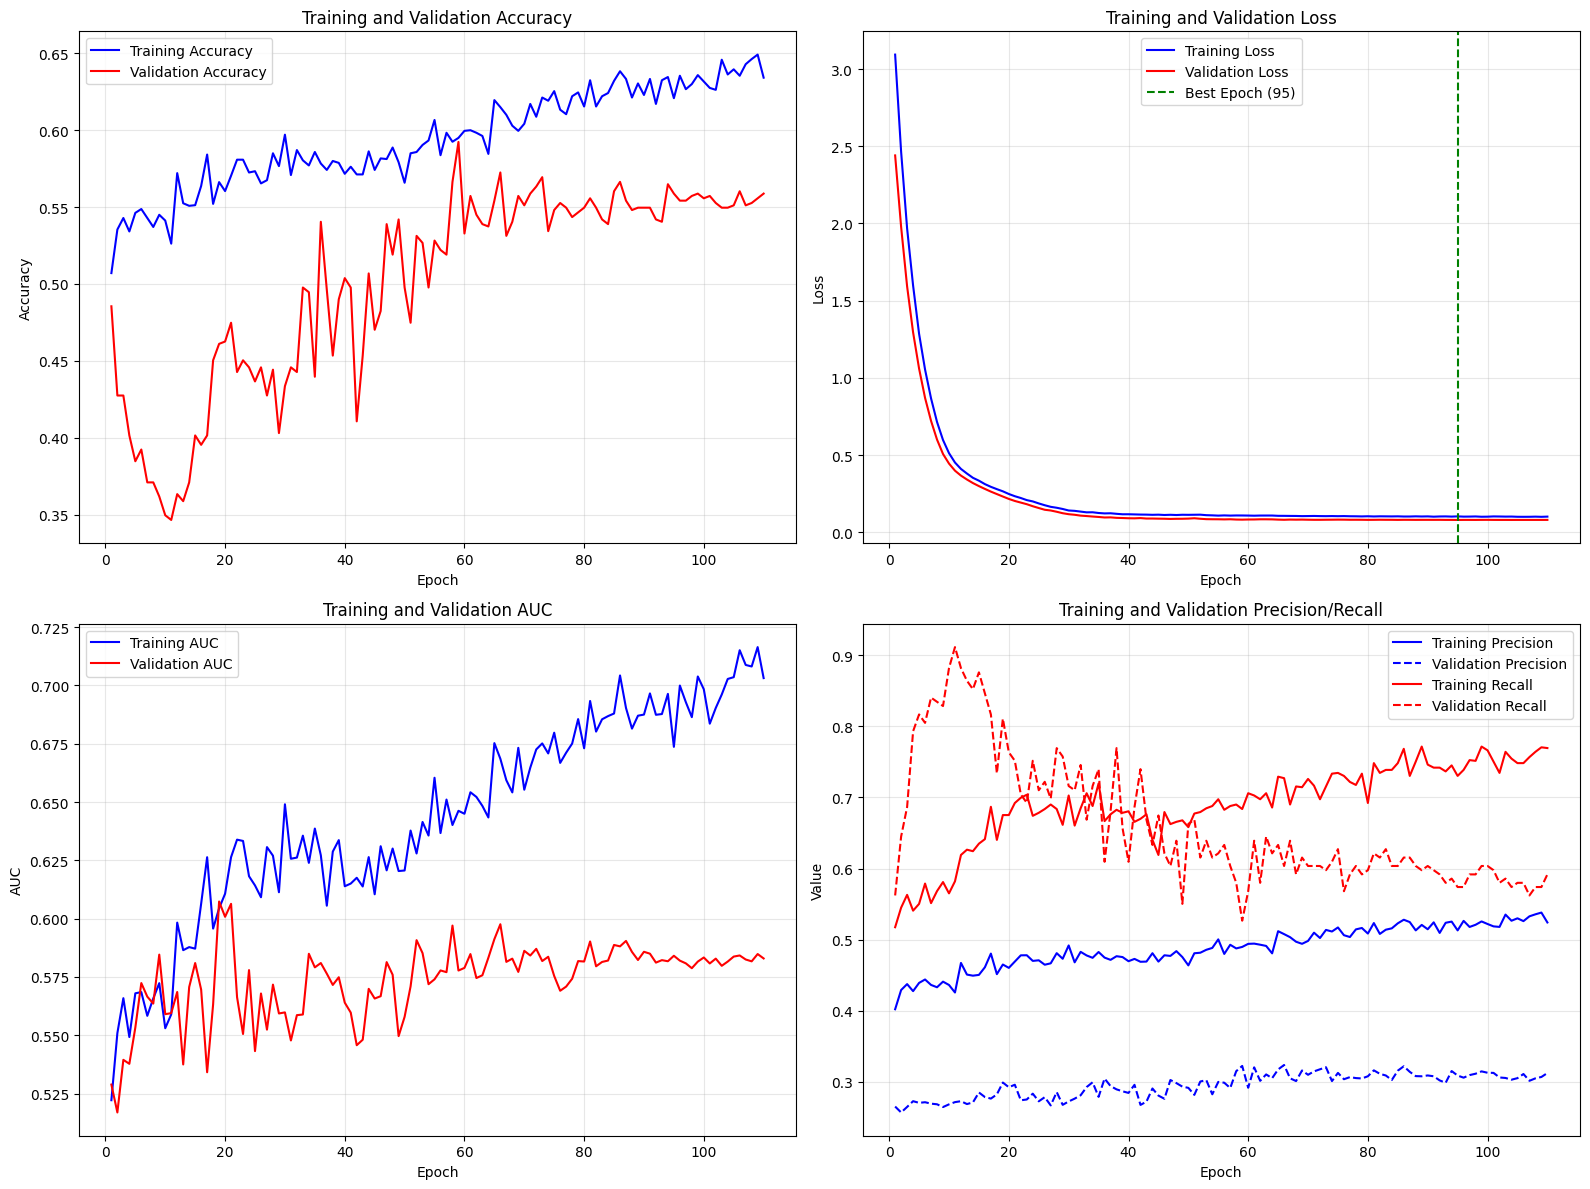

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


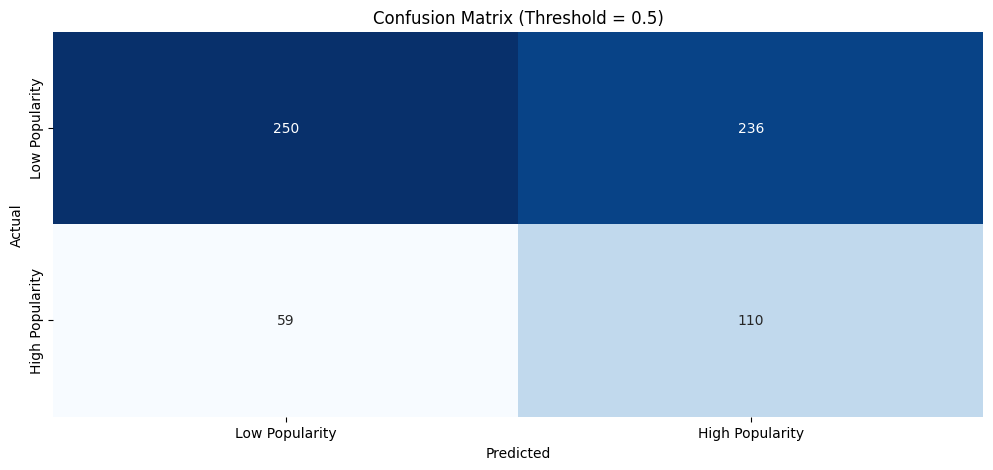


==== Performance Metrics ====
Standard Threshold (0.5):
- Accuracy: 0.5496
- Precision: 0.3179
- Recall: 0.6509
- F1 Score: 0.4272
- AUC: 0.5930

Adjusted Threshold (0.3):
- Accuracy: 0.2641
- Precision: 0.2596
- Recall: 1.0000
- F1 Score: 0.4122
- AUC: 0.5930


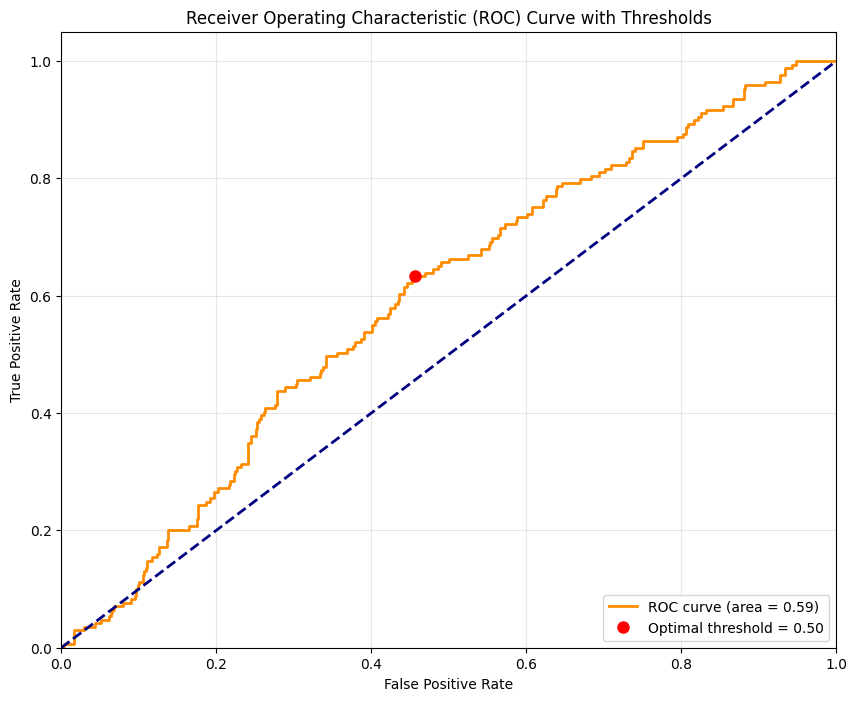

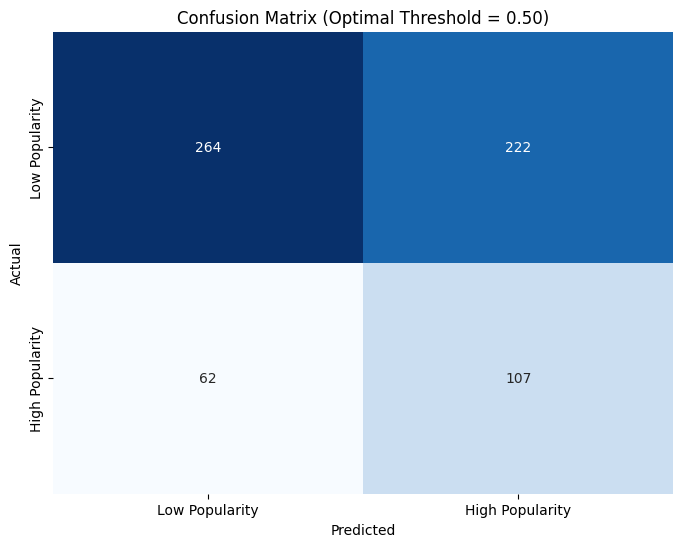


Optimal Threshold (0.5030):
- Accuracy: 0.5664
- Precision: 0.3252
- Recall: 0.6331
- F1 Score: 0.4297
- AUC: 0.5930

FINAL MODEL REPORT AND RECOMMENDATIONS

Class Imbalance Handling:
- Original class distribution: [2427  845] (25.8% positive class)
- SMOTE applied to generate synthetic minority samples
- After SMOTE training class distribution: [1455  945]
- Loss function: Focal Loss (gamma=2, alpha=0.6)
- Optimal classification threshold: 0.5030

Model Performance:
- Test AUC: 0.5930
- Test Accuracy: 0.5664
- Test Precision: 0.3252
- Test Recall: 0.6331
- Test F1 Score: 0.4297


In [31]:

# target - top 25% popularity
y_targ = df.popularity.values
cutoff = np.percentile(y_targ, 75)
y_clf = (y_targ >= cutoff).astype(int)
print(f"Class distribution - Overall: {np.bincount(y_clf)}")
print(f"Class imbalance ratio: 1:{np.bincount(y_clf)[0]/np.bincount(y_clf)[1]:.2f}")

# Calculate class weights based on the imbalance
n_samples = len(y_clf)
n_classes = len(np.unique(y_clf))
class_counts = np.bincount(y_clf)
class_weights = {i: (n_samples / (n_classes * count)) for i, count in enumerate(class_counts)}
print(f"Calculated class weights: {class_weights}")
X = df.drop(columns=['popularity']).values

# Set a lower threshold for prediction
threshold = 0.3 

# train/val/test split
X_train_val, X_test, y_train_val_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42, stratify=y_clf)
X_train, X_val, y_train_clf, y_val_clf = train_test_split(
    X_train_val, y_train_val_clf, test_size=0.25, random_state=42, stratify=y_train_val_clf)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"Training set: {X_train.shape}, Positive class: {sum(y_train_clf)}/{len(y_train_clf)} ({sum(y_train_clf)/len(y_train_clf)*100:.1f}%)")
print(f"Validation set: {X_val.shape}, Positive class: {sum(y_val_clf)}/{len(y_val_clf)} ({sum(y_val_clf)/len(y_val_clf)*100:.1f}%)")
print(f"Test set: {X_test.shape}, Positive class: {sum(y_test_clf)}/{len(y_test_clf)} ({sum(y_test_clf)/len(y_test_clf)*100:.1f}%)")

# Apply SMOTE for imbalance
print("\n==== Applying SMOTE ====")
print(f"Before SMOTE - Training class distribution: {np.bincount(y_train_clf)}")
print(f"Before SMOTE - Training class ratio: 1:{np.bincount(y_train_clf)[0]/np.bincount(y_train_clf)[1]:.2f}")

smote = SMOTE(random_state=42, sampling_strategy=0.65)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train_clf)

# New class distribution
print(f"After SMOTE - Training class distribution: {np.bincount(y_train_smote)}")
print(f"After SMOTE - Training class ratio: 1:{np.bincount(y_train_smote)[0]/np.bincount(y_train_smote)[1]:.2f}")
print(f"Original training set shape: {X_train.shape}, New training set shape: {X_train_smote.shape}")

# Update training data
X_train = X_train_smote
y_train_clf = y_train_smote

# feature selection - random forest
print("\n==== Feature Selection ====")
print("Performing feature selection to reduce dimensionality...")

selector = SelectFromModel(
    RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced'), threshold="median")

# Fit and transform the training data
selector.fit(X_train, y_train_clf)
X_train_selected = selector.transform(X_train)
X_val_selected = selector.transform(X_val)
X_test_selected = selector.transform(X_test)

# Get selected feature indices and names
selected_features_idx = selector.get_support(indices=True)
feature_names = df.drop(columns=['popularity']).columns.tolist()
selected_feature_names = [feature_names[i] for i in selected_features_idx]

print(f"Selected {len(selected_feature_names)} out of {len(feature_names)} features")
print("Selected features:", selected_feature_names[:10], "..." if len(selected_feature_names) > 10 else "")
input_shape = X_train_selected.shape[1]
print(f"New input shape: {input_shape}")


# Build ANN Classification

clf_model = models.Sequential([
    # Input layer
    layers.Input(shape=(input_shape,)),
    layers.Dense(64, activation='relu', 
                 kernel_regularizer=tf.keras.regularizers.l1(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.6), 
    
    # Hidden layer
    layers.Dense(32, activation='relu',
                kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.6),
    
    # Output layer
    layers.Dense(1, activation='sigmoid')])

# Compile model 

# focal loss to address class imbalance
def focal_loss(gamma=3.2, alpha=0.65):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -tf.reduce_mean(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(tf.clip_by_value(pt_1, 1e-8, 1.0))) - \
               tf.reduce_mean((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(tf.clip_by_value(1. - pt_0, 1e-8, 1.0)))
    return focal_loss_fixed

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
clf_model.compile(
    optimizer=optimizer,
    # Use focal loss with alpha > 0.5 to give more importance to minority class
    # Can use smaller alpha now that we've applied SMOTE
    loss=focal_loss(gamma=2, alpha=0.6),
    metrics=[
        'accuracy', 
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()])

# callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,  # Increased patience for SMOTE dataset
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when plateauing
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Custom callback to monitor for overfitting with SMOTE
class SMOTEOverfittingMonitor(callbacks.Callback):
    def __init__(self, threshold=0.2, patience=3):
        super().__init__()
        self.threshold = threshold
        self.patience = patience
        self.gap_history = []
        self.wait = 0
    
    def on_epoch_end(self, epoch, logs=None):
        acc_gap = logs.get('accuracy') - logs.get('val_accuracy')
        self.gap_history.append(acc_gap)
        
        print(f"\nEpoch {epoch+1}: Train-Val accuracy gap: {acc_gap:.4f}")
        
        # gap shouldn't be too large
        if acc_gap > self.threshold:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"\nStopping: Accuracy gap > {self.threshold:.2f} for {self.patience} epochs")
                self.model.stop_training = True
        else:
            self.wait = 0

# Add overfitting monitor
gap_monitor = SMOTEOverfittingMonitor(threshold=0.2, patience=3)

# Train model - with SMOTE we can use milder class weights
history = clf_model.fit(
    X_train_selected, y_train_clf,
    validation_data=(X_val_selected, y_val_clf),
    epochs=120,
    batch_size=32, 
    callbacks=[early_stopping, reduce_lr, gap_monitor],
    class_weight={0: 1.0, 1: 1.7}, 
    verbose=1)

# Evaluate model on test set
print("\n==== Model Evaluation ====")
test_results = clf_model.evaluate(X_test_selected, y_test_clf, verbose=1)
metric_names = ['Loss', 'Accuracy', 'AUC', 'Precision', 'Recall']

for name, value in zip(metric_names, test_results):
    print(f"Test {name}: {value:.4f}")

# Plot history 
def plot_training_history(history):
    plt.figure(figsize=(16, 12))
    
    # Plot accuracy
    plt.subplot(2, 2, 1)
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_acc) + 1)
    
    # Plot main metrics
    plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot loss 
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss')
    
    # Calculate ideal stopping point based on validation loss
    best_epoch = np.argmin(history.history['val_loss']) + 1
    plt.axvline(x=best_epoch, color='green', linestyle='--', label=f'Best Epoch ({best_epoch})')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Check which metric names are available
    auc_keys = [key for key in history.history.keys() if 'auc' in key.lower()]
    val_auc_keys = [key for key in history.history.keys() if 'val' in key.lower() and 'auc' in key.lower()]

    # Plot AUC
    plt.subplot(2, 2, 3)
    if auc_keys and val_auc_keys:
        plt.plot(epochs, history.history[auc_keys[0]], 'b-', label='Training AUC')
        plt.plot(epochs, history.history[val_auc_keys[0]], 'r-', label='Validation AUC')
        plt.title('Training and Validation AUC')
        plt.xlabel('Epoch')
        plt.ylabel('AUC')
        plt.legend()
    else:
        plt.title('AUC metrics not available')
    plt.grid(True, alpha=0.3)
    
    # Plot Precision and Recall - check which metrics are available
    plt.subplot(2, 2, 4)
    precision_keys = [key for key in history.history.keys() if 'precision' in key.lower() and not 'val' in key.lower()]
    val_precision_keys = [key for key in history.history.keys() if 'precision' in key.lower() and 'val' in key.lower()]
    recall_keys = [key for key in history.history.keys() if 'recall' in key.lower() and not 'val' in key.lower()]
    val_recall_keys = [key for key in history.history.keys() if 'recall' in key.lower() and 'val' in key.lower()]
    
    if precision_keys and val_precision_keys:
        plt.plot(epochs, history.history[precision_keys[0]], 'b-', label='Training Precision')
        plt.plot(epochs, history.history[val_precision_keys[0]], 'b--', label='Validation Precision')
    if recall_keys and val_recall_keys:
        plt.plot(epochs, history.history[recall_keys[0]], 'r-', label='Training Recall')
        plt.plot(epochs, history.history[val_recall_keys[0]], 'r--', label='Validation Recall')
    plt.title('Training and Validation Precision/Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history_with_smote.png')
    plt.show()

    return best_epoch

best_epoch = plot_training_history(history)

# Confusion Matrix - predict on test set
y_pred_proba = clf_model.predict(X_test_selected).ravel()

# Use standard threshold (0.5)
y_pred_standard = (y_pred_proba >= 0.5).astype(int)
# Use a lower threshold to favor the minority class
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)  # Using threshold defined earlier (0.3)

# Plot 
cm_standard = confusion_matrix(y_test_clf, y_pred_standard)
plt.figure(figsize=(12, 5))
sns.heatmap(cm_standard, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Low Popularity', 'High Popularity'],
            yticklabels=['Low Popularity', 'High Popularity'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold = 0.5)')
plt.show()

# Calculate metrics for both thresholds
metrics_standard = {
    'Accuracy': accuracy_score(y_test_clf, y_pred_standard),
    'Precision': precision_score(y_test_clf, y_pred_standard, zero_division=0),
    'Recall': recall_score(y_test_clf, y_pred_standard, zero_division=0),
    'F1 Score': f1_score(y_test_clf, y_pred_standard, zero_division=0),
    'AUC': roc_auc_score(y_test_clf, y_pred_proba)}

metrics_adjusted = {
    'Accuracy': accuracy_score(y_test_clf, y_pred_adjusted),
    'Precision': precision_score(y_test_clf, y_pred_adjusted, zero_division=0),
    'Recall': recall_score(y_test_clf, y_pred_adjusted, zero_division=0),
    'F1 Score': f1_score(y_test_clf, y_pred_adjusted, zero_division=0),
    'AUC': roc_auc_score(y_test_clf, y_pred_proba)}

print("\n==== Performance Metrics ====")
print(f"Standard Threshold (0.5):")
for metric, value in metrics_standard.items():
    print(f"- {metric}: {value:.4f}")

print(f"\nAdjusted Threshold ({threshold}):")
for metric, value in metrics_adjusted.items():
    print(f"- {metric}: {value:.4f}")

# Plot ROC curve 
fpr, tpr, thresholds = roc_curve(y_test_clf, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Find the optimal threshold
# Youden's J statistic: J = Sensitivity + Specificity - 1 = tpr + (1-fpr) - 1 = tpr - fpr
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_point = (fpr[optimal_idx], tpr[optimal_idx])

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.plot(optimal_point[0], optimal_point[1], 'ro', markersize=8, 
         label=f'Optimal threshold = {optimal_threshold:.2f}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve with Thresholds')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.show()


# Recalculate predictions with optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
cm_optimal = confusion_matrix(y_test_clf, y_pred_optimal)

# Plot optimal threshold confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Low Popularity', 'High Popularity'],
            yticklabels=['Low Popularity', 'High Popularity'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Optimal Threshold = {optimal_threshold:.2f})')
plt.savefig('optimal_confusion_matrix_with_smote.png')
plt.show()

# Calculate metrics for optimal threshold
metrics_optimal = {
    'Accuracy': accuracy_score(y_test_clf, y_pred_optimal),
    'Precision': precision_score(y_test_clf, y_pred_optimal, zero_division=0),
    'Recall': recall_score(y_test_clf, y_pred_optimal, zero_division=0),
    'F1 Score': f1_score(y_test_clf, y_pred_optimal, zero_division=0),
    'AUC': roc_auc_score(y_test_clf, y_pred_proba)
}

print(f"\nOptimal Threshold ({optimal_threshold:.4f}):")
for metric, value in metrics_optimal.items():
    print(f"- {metric}: {value:.4f}")


# 17. Print final summary and recommendations
print("\n" + "="*50)
print("FINAL MODEL REPORT AND RECOMMENDATIONS")
print("="*50)

print("\nClass Imbalance Handling:")
print(f"- Original class distribution: {np.bincount(y_clf)} ({np.bincount(y_clf)[1]/len(y_clf)*100:.1f}% positive class)")
print(f"- SMOTE applied to generate synthetic minority samples")
print(f"- After SMOTE training class distribution: {np.bincount(y_train_clf)}")
print(f"- Loss function: Focal Loss (gamma=2, alpha=0.6)")
print(f"- Optimal classification threshold: {optimal_threshold:.4f}")

print("\nModel Performance:")
print(f"- Test AUC: {metrics_optimal['AUC']:.4f}")
print(f"- Test Accuracy: {metrics_optimal['Accuracy']:.4f}")
print(f"- Test Precision: {metrics_optimal['Precision']:.4f}")
print(f"- Test Recall: {metrics_optimal['Recall']:.4f}")
print(f"- Test F1 Score: {metrics_optimal['F1 Score']:.4f}")



### TEST WITHOUT YOLO FEATURES

In [11]:
### TEST WITHOUT YOLO FEATURES ###
df = albums.copy()

df = df.drop(['artist_name','artist_id','genre','album_name','release_date','image_url','album_id'],axis=1)

#albums cleaning
#we have percentage color columns
df = df.drop(['black', 'blue', 'gray','orange','red','white','green','pink','yellow','purple'], axis=1)
#group gender diverse categories
group_map = {'non-binary':'gender_diverse',
    'trans woman': 'gender_diverse',
    'genderfluid':'gender_diverse'}
df['gender'] = df['gender'].replace(group_map)

# One‑hot encode the genres/gender
df = pd.get_dummies(df, columns=['genre_condensed'], prefix='genre')
df = pd.get_dummies(df, columns=['gender'], prefix='gender')

# Convert boolean columns to integers
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

print(df.shape)
df.head()

(3289, 40)


,total_tracks,popularity,face,female_genitalia_covered,buttocks_exposed,female_breast_exposed,female_genitalia_exposed,male_breast_exposed,anus_exposed,feet_exposed,...,genre_rap/hip hop,genre_reggae,genre_relaxed,genre_religious,genre_rock/alt,genre_soul/jazz,gender_band,gender_female,gender_gender_diverse,gender_male
0,31,88,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,16,84,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,22,75,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,21,84,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,22,82,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Class distribution - Overall: [2437  852]
Class imbalance ratio: 1:2.86
Calculated class weights: {0: 0.6748050882232253, 1: 1.9301643192488263}
Training set: (1973, 39), Positive class: 511/1973 (25.9%)
Validation set: (658, 39), Positive class: 171/658 (26.0%)
Test set: (658, 39), Positive class: 170/658 (25.8%)

==== Applying SMOTE ====
Before SMOTE - Training class distribution: [1462  511]
Before SMOTE - Training class ratio: 1:2.86
After SMOTE - Training class distribution: [1462  950]
After SMOTE - Training class ratio: 1:1.54
Original training set shape: (1973, 39), New training set shape: (2412, 39)

==== Feature Selection ====
Performing feature selection to reduce dimensionality...


/opt/anaconda3/envs/dsan5400/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Selected 20 out of 39 features
Selected features: ['total_tracks', 'face', 'feet_exposed', 'feet_covered', 'female_breast_covered', 'skin_percentage', 'genre_country/folk', 'genre_electronic', 'genre_kids', 'genre_latin'] ...
New input shape: 20
Epoch 1/120
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5013 - auc_2: 0.5236 - loss: 0.7552 - precision_2: 0.3895 - recall_2: 0.5346
Epoch 1: Train-Val accuracy gap: 0.0801
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5015 - auc_2: 0.5239 - loss: 0.7542 - precision_2: 0.3900 - recall_2: 0.5344 - val_accuracy: 0.4286 - val_auc_2: 0.5805 - val_loss: 0.4952 - val_precision_2: 0.2860 - val_recall_2: 0.8012 - learning_rate: 0.0010
Epoch 2/120
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5492 - auc_2: 0.5773 - loss: 0.6307 - precision_2: 0.4590 - recall_2: 0.5727
Epoch 2: Train-Val accuracy gap: 0.1579
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5475 - auc_2: 0.5752 - loss: 0.6289 - precision_2: 0.4555 - recall_2: 0

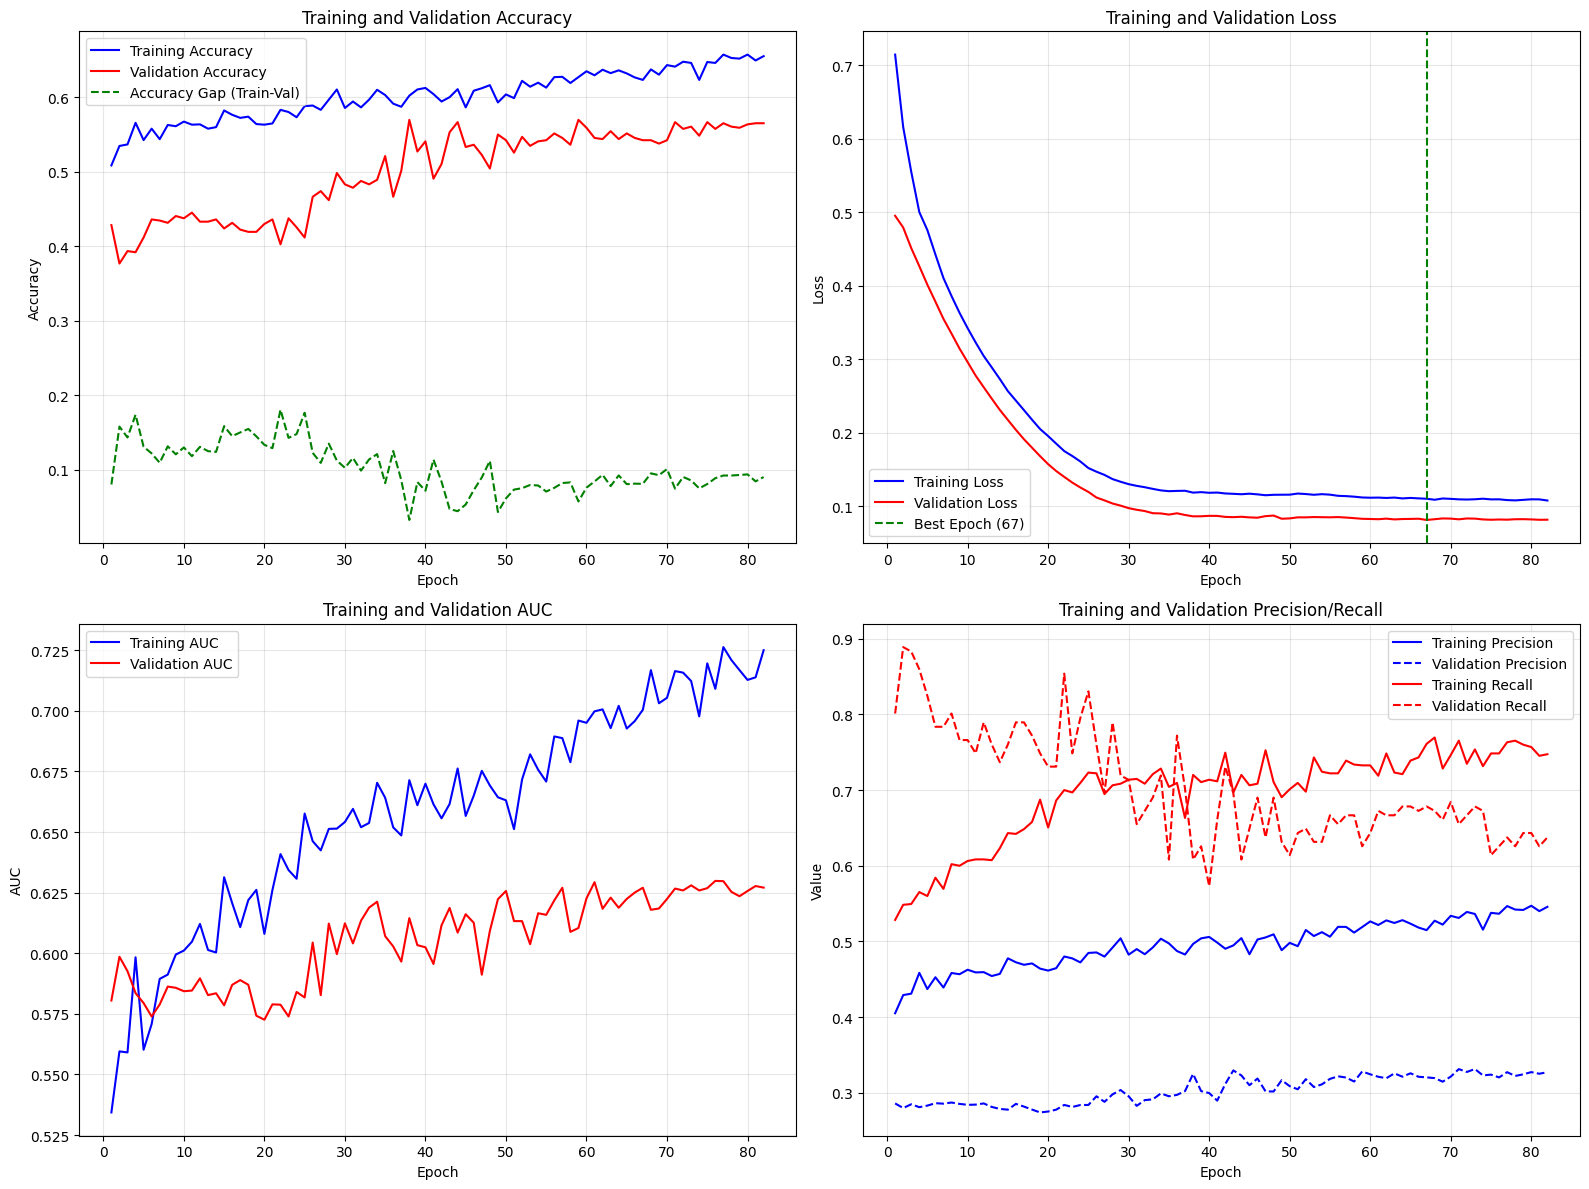

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


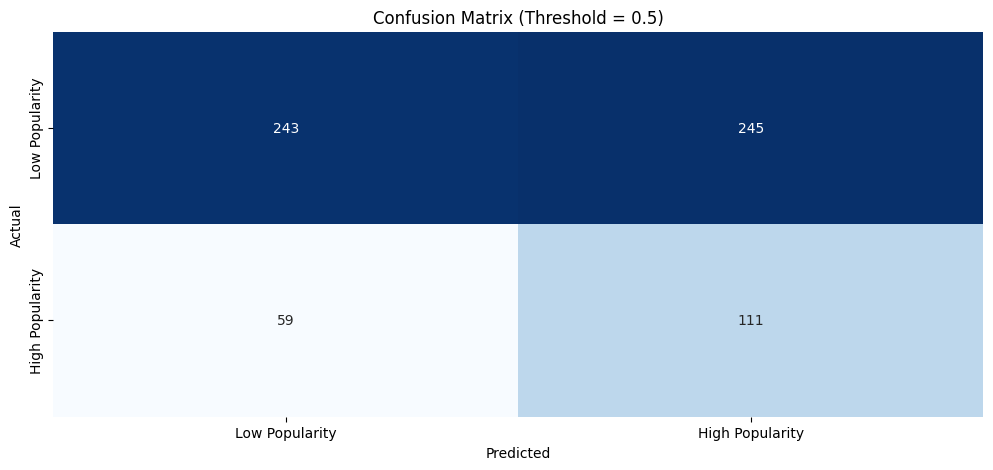


==== Performance Metrics ====
Standard Threshold (0.5):
- Accuracy: 0.5380
- Precision: 0.3118
- Recall: 0.6529
- F1 Score: 0.4221
- AUC: 0.6127

Adjusted Threshold (0.3):
- Accuracy: 0.2614
- Precision: 0.2577
- Recall: 0.9882
- F1 Score: 0.4088
- AUC: 0.6127


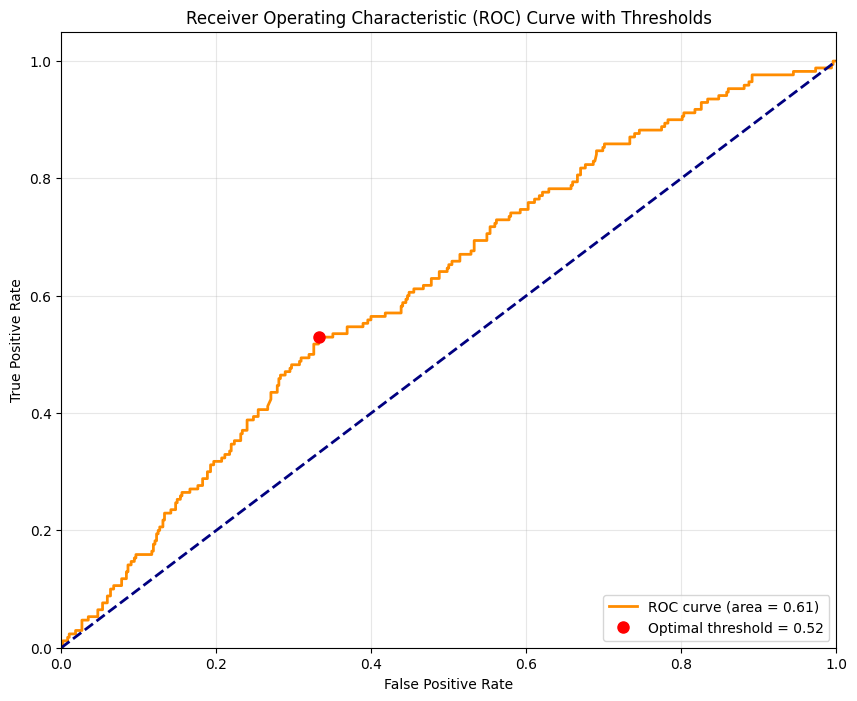

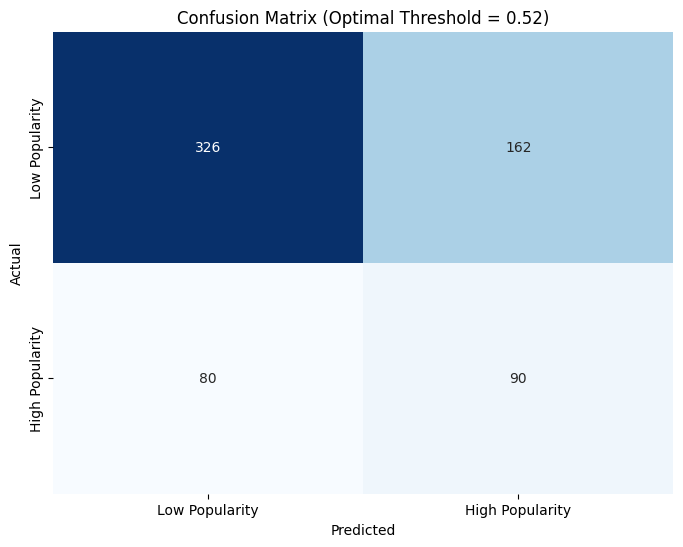


Optimal Threshold (0.5200):
- Accuracy: 0.6322
- Precision: 0.3571
- Recall: 0.5294
- F1 Score: 0.4265
- AUC: 0.6127

FINAL MODEL REPORT AND RECOMMENDATIONS

Class Imbalance Handling:
- Original class distribution: [2437  852] (25.9% positive class)
- SMOTE applied to generate synthetic minority samples
- After SMOTE training class distribution: [1462  950]
- Loss function: Focal Loss (gamma=2, alpha=0.6)
- Optimal classification threshold: 0.5200

Model Performance:
- Test AUC: 0.6127
- Test Accuracy: 0.6322
- Test Precision: 0.3571
- Test Recall: 0.5294
- Test F1 Score: 0.4265

Recommendations:
The model is not performing better than a majority class classifier. Consider:
1. Feature engineering to create more discriminative features
2. Using a more expressive model
3. Trying different preprocessing techniques


In [12]:

# target - top 25% popularity
y_targ = df.popularity.values
cutoff = np.percentile(y_targ, 75)
y_clf = (y_targ >= cutoff).astype(int)
print(f"Class distribution - Overall: {np.bincount(y_clf)}")
print(f"Class imbalance ratio: 1:{np.bincount(y_clf)[0]/np.bincount(y_clf)[1]:.2f}")

# Calculate class weights based on the imbalance
n_samples = len(y_clf)
n_classes = len(np.unique(y_clf))
class_counts = np.bincount(y_clf)
class_weights = {i: (n_samples / (n_classes * count)) for i, count in enumerate(class_counts)}
print(f"Calculated class weights: {class_weights}")
X = df.drop(columns=['popularity']).values

# Set a lower threshold for prediction
threshold = 0.3 

# train/val/test split
X_train_val, X_test, y_train_val_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42, stratify=y_clf)
X_train, X_val, y_train_clf, y_val_clf = train_test_split(
    X_train_val, y_train_val_clf, test_size=0.25, random_state=42, stratify=y_train_val_clf)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"Training set: {X_train.shape}, Positive class: {sum(y_train_clf)}/{len(y_train_clf)} ({sum(y_train_clf)/len(y_train_clf)*100:.1f}%)")
print(f"Validation set: {X_val.shape}, Positive class: {sum(y_val_clf)}/{len(y_val_clf)} ({sum(y_val_clf)/len(y_val_clf)*100:.1f}%)")
print(f"Test set: {X_test.shape}, Positive class: {sum(y_test_clf)}/{len(y_test_clf)} ({sum(y_test_clf)/len(y_test_clf)*100:.1f}%)")

# Apply SMOTE for imbalance
print("\n==== Applying SMOTE ====")
print(f"Before SMOTE - Training class distribution: {np.bincount(y_train_clf)}")
print(f"Before SMOTE - Training class ratio: 1:{np.bincount(y_train_clf)[0]/np.bincount(y_train_clf)[1]:.2f}")

smote = SMOTE(random_state=42, sampling_strategy=0.65)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train_clf)

# New class distribution
print(f"After SMOTE - Training class distribution: {np.bincount(y_train_smote)}")
print(f"After SMOTE - Training class ratio: 1:{np.bincount(y_train_smote)[0]/np.bincount(y_train_smote)[1]:.2f}")
print(f"Original training set shape: {X_train.shape}, New training set shape: {X_train_smote.shape}")

# Update training data
X_train = X_train_smote
y_train_clf = y_train_smote

# feature selection - random forest
print("\n==== Feature Selection ====")
print("Performing feature selection to reduce dimensionality...")

selector = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'), threshold="median")

# Fit and transform the training data
selector.fit(X_train, y_train_clf)
X_train_selected = selector.transform(X_train)
X_val_selected = selector.transform(X_val)
X_test_selected = selector.transform(X_test)

# Get selected feature indices and names
selected_features_idx = selector.get_support(indices=True)
feature_names = df.drop(columns=['popularity']).columns.tolist()
selected_feature_names = [feature_names[i] for i in selected_features_idx]

print(f"Selected {len(selected_feature_names)} out of {len(feature_names)} features")
print("Selected features:", selected_feature_names[:10], "..." if len(selected_feature_names) > 10 else "")
input_shape = X_train_selected.shape[1]
print(f"New input shape: {input_shape}")

# Build ANN Classification

clf_model = models.Sequential([
    # Input layer
    layers.Input(shape=(input_shape,)),
    layers.Dense(64, activation='relu', 
                 kernel_regularizer=tf.keras.regularizers.l1(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4), 
    
    # Hidden layer
    layers.Dense(32, activation='relu',
                kernel_regularizer=tf.keras.regularizers.l1(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    
    # Output layer
    layers.Dense(1, activation='sigmoid')])

# Compile model 

# focal loss to address class imbalance
def focal_loss(gamma=4., alpha=0.8):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -tf.reduce_mean(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(tf.clip_by_value(pt_1, 1e-8, 1.0))) - \
               tf.reduce_mean((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(tf.clip_by_value(1. - pt_0, 1e-8, 1.0)))
    return focal_loss_fixed

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
clf_model.compile(
    optimizer=optimizer,
    # Use focal loss with alpha > 0.5 to give more importance to minority class
    # Can use smaller alpha now that we've applied SMOTE
    loss=focal_loss(gamma=2, alpha=0.6),
    metrics=[
        'accuracy', 
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()])

# callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,  # Increased patience for SMOTE dataset
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when plateauing
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Custom callback to monitor for overfitting with SMOTE
class SMOTEOverfittingMonitor(callbacks.Callback):
    def __init__(self, threshold=0.2, patience=3):
        super().__init__()
        self.threshold = threshold
        self.patience = patience
        self.gap_history = []
        self.wait = 0
    
    def on_epoch_end(self, epoch, logs=None):
        acc_gap = logs.get('accuracy') - logs.get('val_accuracy')
        self.gap_history.append(acc_gap)
        
        print(f"\nEpoch {epoch+1}: Train-Val accuracy gap: {acc_gap:.4f}")
        
        # gap shouldn't be too large
        if acc_gap > self.threshold:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"\nStopping: Accuracy gap > {self.threshold:.2f} for {self.patience} epochs")
                self.model.stop_training = True
        else:
            self.wait = 0

# Add overfitting monitor
gap_monitor = SMOTEOverfittingMonitor(threshold=0.2, patience=3)

# Train model - with SMOTE we can use milder class weights
history = clf_model.fit(
    X_train_selected, y_train_clf,
    validation_data=(X_val_selected, y_val_clf),
    epochs=120,
    batch_size=32, 
    callbacks=[early_stopping, reduce_lr, gap_monitor],
    class_weight={0: 1.0, 1: 2.0},  # Milder weights with SMOTE
    verbose=1)

# Evaluate model on test set
print("\n==== Model Evaluation ====")
test_results = clf_model.evaluate(X_test_selected, y_test_clf, verbose=1)
metric_names = ['Loss', 'Accuracy', 'AUC', 'Precision', 'Recall']

for name, value in zip(metric_names, test_results):
    print(f"Test {name}: {value:.4f}")

# Plot history 
def plot_training_history(history):
    plt.figure(figsize=(16, 12))
    
    # Plot accuracy
    plt.subplot(2, 2, 1)
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_acc) + 1)
    
    # Calculate gap between train and val
    acc_gap = [train - val for train, val in zip(train_acc, val_acc)]
    
    # Plot main metrics
    plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.plot(epochs, acc_gap, 'g--', label='Accuracy Gap (Train-Val)')
    
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot loss 
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss')
    
    # Calculate ideal stopping point based on validation loss
    best_epoch = np.argmin(history.history['val_loss']) + 1
    plt.axvline(x=best_epoch, color='green', linestyle='--', label=f'Best Epoch ({best_epoch})')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Check which metric names are available
    auc_keys = [key for key in history.history.keys() if 'auc' in key.lower()]
    val_auc_keys = [key for key in history.history.keys() if 'val' in key.lower() and 'auc' in key.lower()]

    # Plot AUC
    plt.subplot(2, 2, 3)
    if auc_keys and val_auc_keys:
        plt.plot(epochs, history.history[auc_keys[0]], 'b-', label='Training AUC')
        plt.plot(epochs, history.history[val_auc_keys[0]], 'r-', label='Validation AUC')
        plt.title('Training and Validation AUC')
        plt.xlabel('Epoch')
        plt.ylabel('AUC')
        plt.legend()
    else:
        plt.title('AUC metrics not available')
    plt.grid(True, alpha=0.3)
    
    # Plot Precision and Recall - check which metrics are available
    plt.subplot(2, 2, 4)
    precision_keys = [key for key in history.history.keys() if 'precision' in key.lower() and not 'val' in key.lower()]
    val_precision_keys = [key for key in history.history.keys() if 'precision' in key.lower() and 'val' in key.lower()]
    recall_keys = [key for key in history.history.keys() if 'recall' in key.lower() and not 'val' in key.lower()]
    val_recall_keys = [key for key in history.history.keys() if 'recall' in key.lower() and 'val' in key.lower()]
    
    if precision_keys and val_precision_keys:
        plt.plot(epochs, history.history[precision_keys[0]], 'b-', label='Training Precision')
        plt.plot(epochs, history.history[val_precision_keys[0]], 'b--', label='Validation Precision')
    if recall_keys and val_recall_keys:
        plt.plot(epochs, history.history[recall_keys[0]], 'r-', label='Training Recall')
        plt.plot(epochs, history.history[val_recall_keys[0]], 'r--', label='Validation Recall')
    plt.title('Training and Validation Precision/Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history_with_smote.png')
    plt.show()

    return best_epoch

best_epoch = plot_training_history(history)

# Confusion Matrix - predict on test set
y_pred_proba = clf_model.predict(X_test_selected).ravel()

# Use standard threshold (0.5)
y_pred_standard = (y_pred_proba >= 0.5).astype(int)
# Use a lower threshold to favor the minority class
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)  # Using threshold defined earlier (0.3)

# Plot 
cm_standard = confusion_matrix(y_test_clf, y_pred_standard)
plt.figure(figsize=(12, 5))
sns.heatmap(cm_standard, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Low Popularity', 'High Popularity'],
            yticklabels=['Low Popularity', 'High Popularity'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold = 0.5)')
plt.show()

# Calculate metrics for both thresholds
metrics_standard = {
    'Accuracy': accuracy_score(y_test_clf, y_pred_standard),
    'Precision': precision_score(y_test_clf, y_pred_standard, zero_division=0),
    'Recall': recall_score(y_test_clf, y_pred_standard, zero_division=0),
    'F1 Score': f1_score(y_test_clf, y_pred_standard, zero_division=0),
    'AUC': roc_auc_score(y_test_clf, y_pred_proba)}

metrics_adjusted = {
    'Accuracy': accuracy_score(y_test_clf, y_pred_adjusted),
    'Precision': precision_score(y_test_clf, y_pred_adjusted, zero_division=0),
    'Recall': recall_score(y_test_clf, y_pred_adjusted, zero_division=0),
    'F1 Score': f1_score(y_test_clf, y_pred_adjusted, zero_division=0),
    'AUC': roc_auc_score(y_test_clf, y_pred_proba)}

print("\n==== Performance Metrics ====")
print(f"Standard Threshold (0.5):")
for metric, value in metrics_standard.items():
    print(f"- {metric}: {value:.4f}")

print(f"\nAdjusted Threshold ({threshold}):")
for metric, value in metrics_adjusted.items():
    print(f"- {metric}: {value:.4f}")

# Plot ROC curve 
fpr, tpr, thresholds = roc_curve(y_test_clf, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Find the optimal threshold
# Youden's J statistic: J = Sensitivity + Specificity - 1 = tpr + (1-fpr) - 1 = tpr - fpr
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_point = (fpr[optimal_idx], tpr[optimal_idx])

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.plot(optimal_point[0], optimal_point[1], 'ro', markersize=8, 
         label=f'Optimal threshold = {optimal_threshold:.2f}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve with Thresholds')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.show()


# Recalculate predictions with optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
cm_optimal = confusion_matrix(y_test_clf, y_pred_optimal)

# Plot optimal threshold confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Low Popularity', 'High Popularity'],
            yticklabels=['Low Popularity', 'High Popularity'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Optimal Threshold = {optimal_threshold:.2f})')
plt.savefig('optimal_confusion_matrix_with_smote.png')
plt.show()

# Calculate metrics for optimal threshold
metrics_optimal = {
    'Accuracy': accuracy_score(y_test_clf, y_pred_optimal),
    'Precision': precision_score(y_test_clf, y_pred_optimal, zero_division=0),
    'Recall': recall_score(y_test_clf, y_pred_optimal, zero_division=0),
    'F1 Score': f1_score(y_test_clf, y_pred_optimal, zero_division=0),
    'AUC': roc_auc_score(y_test_clf, y_pred_proba)
}

print(f"\nOptimal Threshold ({optimal_threshold:.4f}):")
for metric, value in metrics_optimal.items():
    print(f"- {metric}: {value:.4f}")


# 17. Print final summary and recommendations
print("\n" + "="*50)
print("FINAL MODEL REPORT AND RECOMMENDATIONS")
print("="*50)

print("\nClass Imbalance Handling:")
print(f"- Original class distribution: {np.bincount(y_clf)} ({np.bincount(y_clf)[1]/len(y_clf)*100:.1f}% positive class)")
print(f"- SMOTE applied to generate synthetic minority samples")
print(f"- After SMOTE training class distribution: {np.bincount(y_train_clf)}")
print(f"- Loss function: Focal Loss (gamma=2, alpha=0.6)")
print(f"- Optimal classification threshold: {optimal_threshold:.4f}")

print("\nModel Performance:")
print(f"- Test AUC: {metrics_optimal['AUC']:.4f}")
print(f"- Test Accuracy: {metrics_optimal['Accuracy']:.4f}")
print(f"- Test Precision: {metrics_optimal['Precision']:.4f}")
print(f"- Test Recall: {metrics_optimal['Recall']:.4f}")
print(f"- Test F1 Score: {metrics_optimal['F1 Score']:.4f}")

print("\nRecommendations:")
# Check if the model is doing better than always predicting majority class
majority_accuracy = max(np.bincount(y_test_clf)) / len(y_test_clf)

if metrics_optimal['AUC'] < 0.6:
    print("The model shows weak discriminative power (AUC < 0.6). Consider:")
    print("1. Trying different SMOTE parameters or other sampling techniques (ADASYN, BorderlineSMOTE)")
    print("2. Feature engineering to create more discriminative features")
    print("3. Using a different model architecture (e.g., Gradient Boosting)")
    
elif metrics_optimal['Accuracy'] <= majority_accuracy:
    print("The model is not performing better than a majority class classifier. Consider:")
    print("1. Feature engineering to create more discriminative features")
    print("2. Using a more expressive model")
    print("3. Trying different preprocessing techniques")
    
else:
    print("The model shows good performance with SMOTE and class imbalance handling. To further improve:")
    print("1. Fine-tune the SMOTE sampling_strategy parameter")
    print("2. Consider ensemble methods combining multiple models")
    print("3. Focus on the top important features for feature engineering")

TUNER

In [111]:
 import keras_tuner as kt
from tensorflow import keras
import tensorflow as tf
import numpy as np
import time
import math

# Function to estimate tuning time
def estimate_tuning_time(tuner, avg_epoch_time=2.0):
    """
    Estimate the tuning time based on the tuner configuration.
    
    Parameters:
    - tuner: The Hyperband tuner
    - avg_epoch_time: Average time per epoch in seconds (adjust based on your hardware)
    
    Returns:
    - Estimated time in hours
    """
    # Get the Hyperband parameters
    max_epochs = tuner.hyperband_iterations[0].max_epochs
    factor = tuner.hyperband_iterations[0].reduction_factor
    
    # Count the number of models and epochs
    total_epochs = 0
    models = 0
    
    # Calculate based on Hyperband formula
    for i in range(int(math.log(max_epochs, factor)) + 1):
        n_i = int(math.ceil(int(max_epochs * factor**i) / (max_epochs * factor**(-i))))
        r_i = max_epochs * factor**(-i)
        
        models += n_i
        total_epochs += n_i * r_i
    
    # Calculate the estimated time
    estimated_time_seconds = total_epochs * avg_epoch_time
    estimated_time_hours = estimated_time_seconds / 3600
    
    return estimated_time_hours, models, int(total_epochs)

# Define the model-building function with hyperparameters to tune
def build_model(hp):
    """Build model with hyperparameters to tune"""
    
    # Parameters to search
    units_layer1 = hp.Int('units_layer1', min_value=16, max_value=128, step=16)
    units_layer2 = hp.Int('units_layer2', min_value=8, max_value=64, step=8)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    learning_rate = hp.Choice('learning_rate', values=[1e-4, 5e-4, 1e-3, 5e-3])
    l1_reg = hp.Float('l1_reg', min_value=1e-4, max_value=1e-2, sampling='log')
    alpha = hp.Float('focal_loss_alpha', min_value=0.5, max_value=0.9, step=0.1)
    gamma = hp.Int('focal_loss_gamma', min_value=1, max_value=5, step=1)
    
    # Build model with the hyperparameters
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(input_shape,)))
    
    # First layer
    model.add(keras.layers.Dense(
        units=units_layer1,
        activation='relu',
        kernel_regularizer=keras.regularizers.l1(l1_reg)
    ))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(dropout_rate))
    
    # Optional second layer based on hyperparameter
    if hp.Boolean('second_layer'):
        model.add(keras.layers.Dense(
            units=units_layer2,
            activation='relu',
            kernel_regularizer=keras.regularizers.l1(l1_reg)
        ))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dropout(dropout_rate))
    
    # Output layer
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    # Compile model with focal loss
    def focal_loss_with_params(y_true, y_pred):
        # Use the alpha and gamma from hyperparameters
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -tf.reduce_mean(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(tf.clip_by_value(pt_1, 1e-8, 1.0))) - \
               tf.reduce_mean((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(tf.clip_by_value(1. - pt_0, 1e-8, 1.0)))
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss=focal_loss_with_params,
        metrics=['accuracy', keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()]
    )
    
    return model

# Set up early stopping and callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Initialize the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_auc',  # Maximize validation AUC
    max_epochs=50,
    factor=3,
    directory='keras_tuner_dir',
    project_name='popularity_prediction'
)

# Display the search space summary
tuner.search_space_summary()

# Estimate the tuning time
# First, let's run a quick test to measure average epoch time
print("\nMeasuring average epoch time for estimation...")
test_model = build_model(kt.HyperParameters())
start_time = time.time()
# Run a single epoch to measure time
test_model.fit(
    X_train_selected, y_train_clf,
    epochs=1,
    batch_size=32,
    verbose=0
)
end_time = time.time()
avg_epoch_time = end_time - start_time
print(f"Average epoch time: {avg_epoch_time:.2f} seconds")

# For Hyperband, we can make a simplified estimate
# In Hyperband with max_epochs=50 and factor=3:
# We'll have approximately 20-30 models with varying epochs
estimated_models = 25  # Approximation
avg_epochs_per_model = 20  # With early stopping, models won't run full 50 epochs
total_estimated_epochs = estimated_models * avg_epochs_per_model
estimated_time_seconds = total_estimated_epochs * avg_epoch_time
estimated_time_hours = estimated_time_seconds / 3600

print(f"\nTuning Time Estimate:")
print(f"- Approximately {estimated_models} models will be trained")
print(f"- Average of ~{avg_epochs_per_model} epochs per model (with early stopping)")
print(f"- Total of ~{total_estimated_epochs} epochs across all models")
print(f"- Estimated time: {estimated_time_hours:.2f} hours")
print(f"- This is a rough estimate; actual time may vary by 20-40%")

# Ask for confirmation before proceeding
proceed = input("\nDo you want to proceed with hyperparameter tuning? (y/n): ").lower()
if proceed != 'y':
    print("Tuning cancelled.")
    import sys
    sys.exit(0)

print("\nStarting hyperparameter tuning...")
start_total_time = time.time()

# Define a custom callback to balance time and performance
class F1ScoreCallback(keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(F1ScoreCallback, self).__init__()
        self.validation_data = validation_data
        
    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        y_pred = (self.model.predict(x_val) > 0.5).astype("int32")
        
        from sklearn.metrics import f1_score, precision_score, recall_score
        precision = precision_score(y_val, y_pred, zero_division=0)
        recall = recall_score(y_val, y_pred, zero_division=0)
        f1 = f1_score(y_val, y_pred, zero_division=0)
        
        logs['val_f1'] = f1
        logs['val_precision_custom'] = precision
        logs['val_recall_custom'] = recall
        
        print(f" — val_f1: {f1:.4f}, val_precision_custom: {precision:.4f}, val_recall_custom: {recall:.4f}")

# Running the hyperparameter search
tuner.search(
    X_train_selected, y_train_clf,
    epochs=50,
    validation_data=(X_val_selected, y_val_clf),
    callbacks=[early_stopping, reduce_lr, F1ScoreCallback((X_val_selected, y_val_clf))],
    class_weight={0: 1.0, 1: 1.5}
)

# Calculate actual time taken
end_total_time = time.time()
actual_hours = (end_total_time - start_total_time) / 3600
print(f"\nActual tuning time: {actual_hours:.2f} hours")

# Get the best hyperparameters and build the model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best hyperparameters found:
- units_layer1: {best_hps.get('units_layer1')}
- units_layer2: {best_hps.get('units_layer2')}
- dropout_rate: {best_hps.get('dropout_rate')}
- learning_rate: {best_hps.get('learning_rate')}
- l1_reg: {best_hps.get('l1_reg')}
- focal_loss_alpha: {best_hps.get('focal_loss_alpha')}
- focal_loss_gamma: {best_hps.get('focal_loss_gamma')}
- second_layer: {best_hps.get('second_layer')}
""")

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

print("\nTraining final model with best hyperparameters...")
# Final training with the best model
history = best_model.fit(
    X_train_selected, y_train_clf,
    epochs=100,  # Higher max_epochs since we'll early stop anyway
    validation_data=(X_val_selected, y_val_clf),
    callbacks=[early_stopping, reduce_lr, F1ScoreCallback((X_val_selected, y_val_clf))],
    class_weight={0: 1.0, 1: 1.5},
    verbose=1
)

# Evaluate the best model
test_results = best_model.evaluate(X_test_selected, y_test_clf, verbose=1)
metric_names = ['Loss', 'Accuracy', 'AUC', 'Precision', 'Recall']

print("\n==== Best Model Evaluation ====")
for name, value in zip(metric_names, test_results):
    print(f"Test {name}: {value:.4f}")

# Generate predictions with the best model
y_pred_proba = best_model.predict(X_test_selected).ravel()
y_pred = (y_pred_proba >= 0.5).astype(int)

# Calculate metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

print("\nClassification Report:")
print(classification_report(y_test_clf, y_pred))

# Find optimal threshold
fpr, tpr, thresholds = roc_curve(y_test_clf, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Youden's J statistic
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\nOptimal threshold (Youden's J): {optimal_threshold:.4f}")

# Predictions with optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test_clf, y_pred_optimal))

# Plot confusion matrix with optimal threshold
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_clf, y_pred_optimal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Low Popularity', 'High Popularity'],
            yticklabels=['Low Popularity', 'High Popularity'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Optimal Threshold = {optimal_threshold:.2f})')
plt.savefig('optimal_confusion_matrix_tuned.png')
plt.show()

# Save the best model
best_model.save('best_tuned_model.h5')
print("\nBest model saved as 'best_tuned_model.h5'")

Trial 30 Complete [00h 00m 08s]
val_auc: 0.587485134601593

Best val_auc So Far: 0.5995053052902222
Total elapsed time: 00h 06m 32s

Search: Running Trial #31

Value             |Best Value So Far |Hyperparameter
32                |112               |units_layer1
40                |8                 |units_layer2
0.5               |0.1               |dropout_rate
0.0001            |0.001             |learning_rate
0.00041765        |0.005399          |l1_reg
0.6               |0.8               |focal_loss_alpha
2                 |3                 |focal_loss_gamma
True              |False             |second_layer
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
